In [1]:
import pandas as pd
import numpy as np
from random import randint, choice
import scipy.stats as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib 

sns.set(rc={'figure.figsize': (7, 5)}, style='whitegrid')

In [2]:
n_row = 10000
list_clicks = []
list_views = []
list_groups = []
list_users = []
current_user = 1
n_group = [1,2]

for _ in tqdm(range(n_row)):
  list_groups.append(choice(n_group))
  list_users.append(current_user)
  if list_users[:-1] == 1:
    list_clicks.append(randint(0,30))
  else:
    list_clicks.append(randint(5,55))  
  list_views.append(randint(80,150))

  current_user = current_user + 1


  0%|          | 0/10000 [00:00<?, ?it/s]

In [3]:
df = pd.DataFrame({'group':list_groups,
                   'user':list_users,
                   'clicks':list_clicks,
                   'views':list_views})

In [4]:
df['ctr'] = df['clicks']/df['views']

In [5]:
df.head()

,group,user,clicks,views,ctr
0,1,1,28,122,0.229508
1,1,2,14,88,0.159091
2,2,3,48,118,0.406780
3,1,4,5,113,0.044248
4,1,5,38,81,0.469136


In [6]:
df_control = df[df['group']==1].drop('group', axis = 1).copy(deep=True)
df_test = df[df['group']==2].drop('group', axis = 1).copy(deep=True)

### poisson_bootstrap

In [7]:
n_control = df_control.shape[0]
n_test = df_test.shape[0]
print((n_control + n_test) == 10000)

True


In [8]:
n_samples = 5000
poisson_samples_control = stats.poisson(1).rvs((n_samples, n_control))
poisson_samples_test = stats.poisson(1).rvs((n_samples, n_test))

In [9]:
poisson_ctr_control = ((poisson_samples_control  * df_control['clicks'].to_numpy()).sum(axis=1) / 
                       (poisson_samples_control * df_control['views'].to_numpy()).sum(axis=1))
poisson_ctr_test = ((poisson_samples_test * df_test['clicks'].to_numpy()).sum(axis=1) / 
                    (poisson_samples_test * df_test['views'].to_numpy()).sum(axis=1))

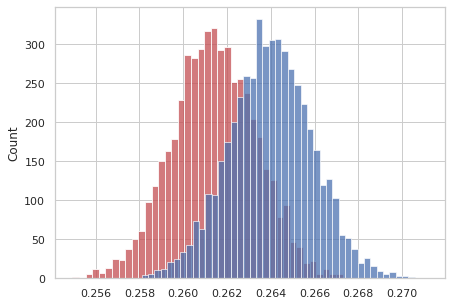

In [10]:
sns.histplot(poisson_ctr_control, color='r')
sns.histplot(poisson_ctr_test, color='b')

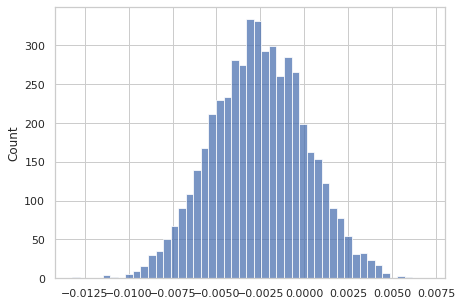

In [11]:
sns.histplot(poisson_ctr_control - poisson_ctr_test)

### smothed_ctr

In [12]:
def smoothed_ctr(like, view, general_ctr, alpha):
    return (like + alpha*general_ctr) / (view + alpha)

In [13]:
global_ctr_control = df_control['clicks'].sum() / df_control['views'].sum()
global_ctr_test = df_test['clicks'].sum() / df_test['views'].sum()

In [14]:
df_control['smoothed_ctr'] = df_control.apply(
    lambda x: smoothed_ctr(x['clicks'], x['views'], global_ctr_control, 5), axis=1)

df_test['smoothed_ctr'] = df_test.apply(
    lambda x: smoothed_ctr(x['clicks'], x['views'], global_ctr_test, 5), axis=1)

In [15]:
print(f"before {stats.ttest_ind(df_control['ctr'], df_test['ctr'], equal_var=False)}")
print(f"after smoothed ctr {stats.ttest_ind(df_control['smoothed_ctr'], df_test['smoothed_ctr'], equal_var=False)}")

before Ttest_indResult(statistic=-0.7952891805234122, pvalue=0.42646419768241906)
after smoothed ctr Ttest_indResult(statistic=-0.8433714051867772, pvalue=0.39904094846198723)


In [16]:
print(f"before {stats.mannwhitneyu(df_control['ctr'], df_test['ctr'])}")
print(f"after smoothed ctr {stats.mannwhitneyu(df_control['smoothed_ctr'], df_test['smoothed_ctr'])}")

before MannwhitneyuResult(statistic=12365853.0, pvalue=0.3625697000127063)
after smoothed ctr MannwhitneyuResult(statistic=12357019.0, pvalue=0.33120657536192066)


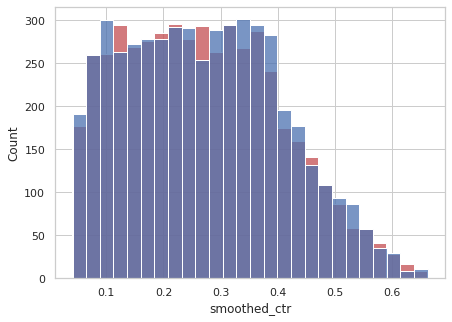

In [17]:
sns.histplot(df_control['smoothed_ctr'], color='r')
sns.histplot(df_test['smoothed_ctr'], color='b')

### bucket_conversion

In [18]:
def get_hash_modulo(value: str, modulo: int = 100, salt: str = 'test'):
    """Вычисляем остаток от деления: hash(value + salt) % modulo"""
    hash_value = int(hashlib.md5(str.encode(str(value) + str(salt))).hexdigest(), 16)
    return hash_value % modulo

In [19]:
df_control['backet'] = df_control['user'].apply(get_hash_modulo)
df_test['backet'] = df_test['user'].apply(get_hash_modulo)

In [20]:
df_control.head()

,user,clicks,views,ctr,smoothed_ctr,backet
0,1,28,122,0.229508,0.230766,45
1,2,14,88,0.159091,0.164595,67
3,4,5,113,0.044248,0.053452,7
4,5,38,81,0.469136,0.457062,58
5,6,39,99,0.393939,0.387570,24


In [21]:
df_test.head()

,user,clicks,views,ctr,smoothed_ctr,backet
2,3,48,118,0.406780,0.400976,4
6,7,23,97,0.237113,0.238432,35
9,10,35,139,0.251799,0.252223,61
10,11,23,111,0.207207,0.209656,6
13,14,51,102,0.500000,0.488972,99


In [22]:
df_control_backet = df_control.groupby('backet')['clicks'].sum() / df_control.groupby('backet')['views'].sum()
df_test_backet = df_test.groupby('backet')['clicks'].sum() / df_test.groupby('backet')['views'].sum()

In [23]:
print(f"before {stats.ttest_ind(df_control['ctr'], df_test['ctr'], equal_var=False)}")
print(f"after smoothed ctr {stats.ttest_ind(df_control['smoothed_ctr'], df_test['smoothed_ctr'], equal_var=False)}")
print(f"after bucket conversion {stats.ttest_ind(df_control_backet, df_test_backet, equal_var=False)}")

before Ttest_indResult(statistic=-0.7952891805234122, pvalue=0.42646419768241906)
after smoothed ctr Ttest_indResult(statistic=-0.8433714051867772, pvalue=0.39904094846198723)
after bucket conversion Ttest_indResult(statistic=-0.9380092736994796, pvalue=0.3494153353162901)


In [24]:
print(f"before {stats.mannwhitneyu(df_control['ctr'], df_test['ctr'])}")
print(f"after smoothed_ctr {stats.mannwhitneyu(df_control['smoothed_ctr'], df_test['smoothed_ctr'])}")
print(f"after bucket conversion {stats.mannwhitneyu(df_control_backet, df_test_backet)}")

before MannwhitneyuResult(statistic=12365853.0, pvalue=0.3625697000127063)
after smoothed_ctr MannwhitneyuResult(statistic=12357019.0, pvalue=0.33120657536192066)
after bucket conversion MannwhitneyuResult(statistic=4595.0, pvalue=0.32298087183735025)
